In [1]:
import numpy as np
import matplotlib.pyplot as plt
import segyio
import pylops

In [3]:
# Caso tenha o dado de ABL, descomentar a linha abaixo
filename = "C:/users/aalbano/desktop/dados/ABL_FULL_TIME_3D.sgy"

In [4]:
f = segyio.open(filename, ignore_geometry=True)

traces = segyio.collect(f.trace)[:]
ntraces, nt = traces.shape

t = f.samples
il = f.attributes(189)[:]
xl = f.attributes(193)[:]

# Define regular IL and XL axes
il_unique = np.unique(il)
xl_unique = np.unique(xl)

il_min, il_max = min(il_unique), max(il_unique)
xl_min, xl_max = min(xl_unique), max(xl_unique)

dt = t[1] - t[0]
dil = min(np.unique(np.diff(il_unique)))
dxl = min(np.unique(np.diff(xl_unique)))

ilines = np.arange(il_min, il_max + dil, dil)
xlines = np.arange(xl_min, xl_max + dxl, dxl)
nil, nxl = ilines.size, xlines.size

ilgrid, xlgrid = np.meshgrid(np.arange(nil),
                             np.arange(nxl),
                             indexing='ij')

# Look-up table
traces_indeces = np.full((nil, nxl), np.nan)
iils = (il - il_min) // dil
ixls = (xl - xl_min) // dxl
traces_indeces[iils, ixls] = np.arange(ntraces)
traces_available = np.logical_not(np.isnan(traces_indeces))

# Reorganize traces in regular grid
d = np.zeros((nil, nxl, nt))
d[ilgrid.ravel()[traces_available.ravel()],
  xlgrid.ravel()[traces_available.ravel()]] = traces

nil, nxl, nt = len(ilines), len(xlines), len(t)

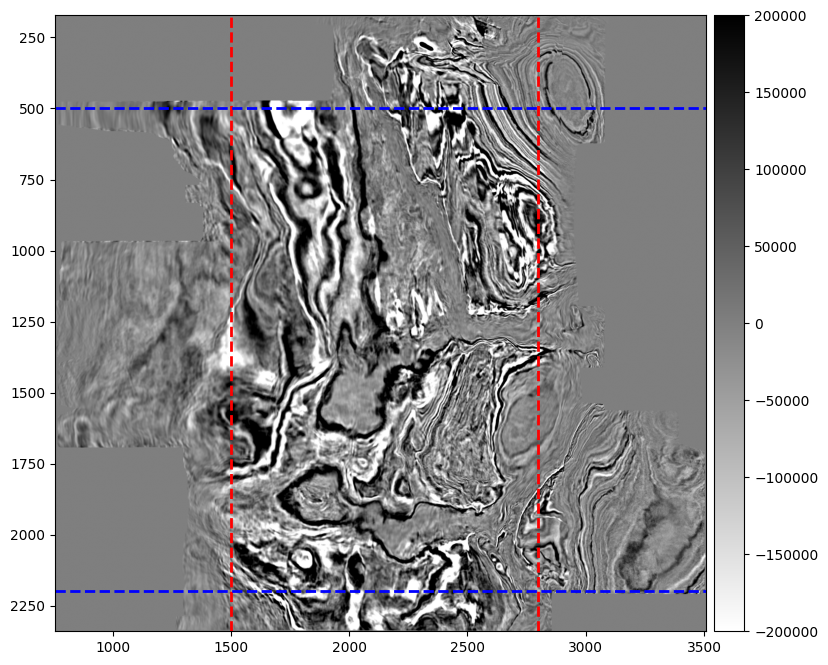

In [5]:
#plotting data
fig, ax = plt.subplots(figsize=(10, 8))


c=ax.imshow(d[..., 1400], aspect='auto', cmap='gray_r', vmin=-200000, vmax=200000,
            extent=[xl_min, xl_max, il_max, il_min])

# Adicionando linhas verticais e horizontais em posições arbitrárias
ax.axvline(x = 1500, color='red', linestyle='--', linewidth=2)  # Linha vertical
ax.axvline(x = 2800, color='red', linestyle='--', linewidth=2)  # Linha vertical
ax.axhline(y = 500, color='blue', linestyle='--', linewidth=2)  # Linha horizontal
ax.axhline(y = 2200, color='blue', linestyle='--', linewidth=2)  # Linha horizontal

plt.colorbar(c, ax=ax, pad=0.01)
plt.grid(False)

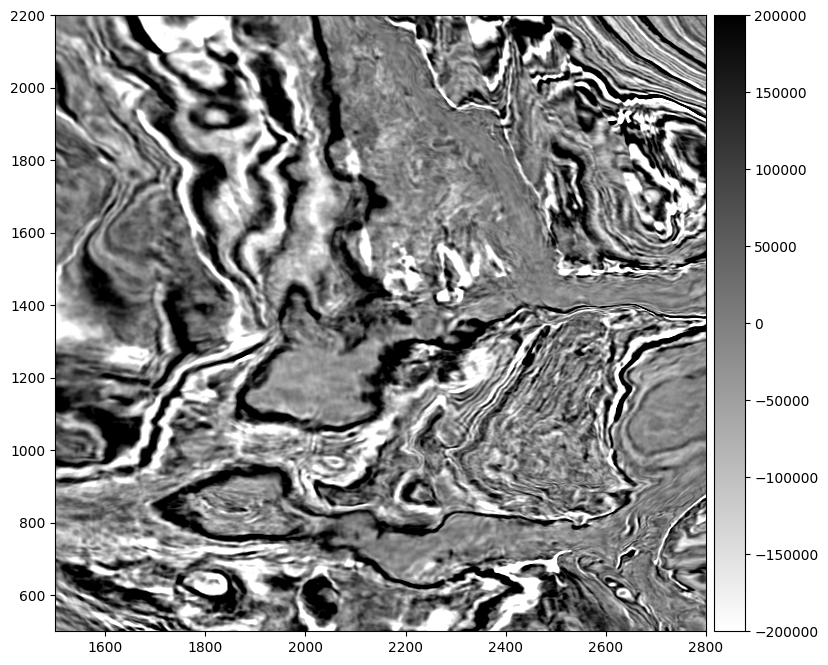

In [22]:
#plotting data
fig, ax = plt.subplots(figsize=(10, 8))


c=ax.imshow(d[500 - il_min: 2220 - il_min, 1500 - xl_min : 2800 - xl_min, 1400], aspect='auto', cmap='gray_r', vmin=-200000, vmax=200000,
            extent=[1500, 2800, 500, 2200])

plt.colorbar(c, ax=ax, pad=0.01)
plt.grid(False)

In [6]:
d = d[500 - il_min: 2220 - il_min, 1500 - xl_min : 2800 - xl_min, :]

In [10]:
np.save('dado_recortado.npy', d)

In [ ]:
abc = np.load('dado_recortado.npy')

(4000.0, 1000.0)

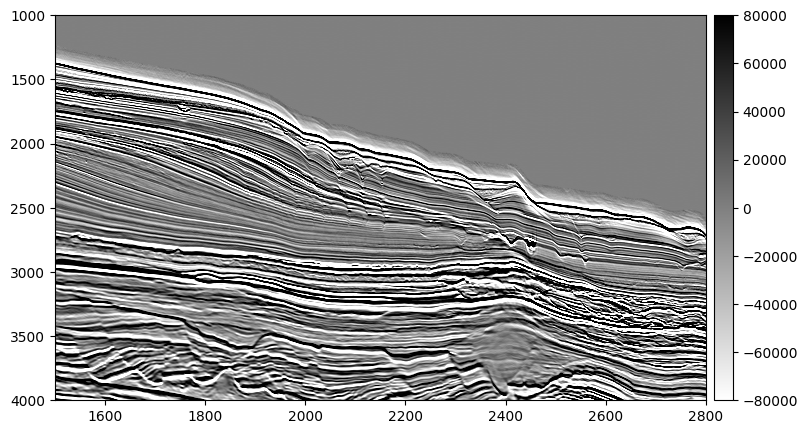

In [33]:
#plotting data
fig, ax = plt.subplots(figsize=(10, 5))
c=ax.imshow(d[500, :, :].T, aspect='auto', cmap='gray_r', vmin=-8e4, vmax=8e4,
            extent=[1500, 2800, t[-1], t[0]])


plt.colorbar(c, ax=ax, pad=0.01)
#ax.set_xlim(4000, 7000)
plt.grid(False)
ax.set_ylim(4000, 1000)

(650.0, 1650.0)

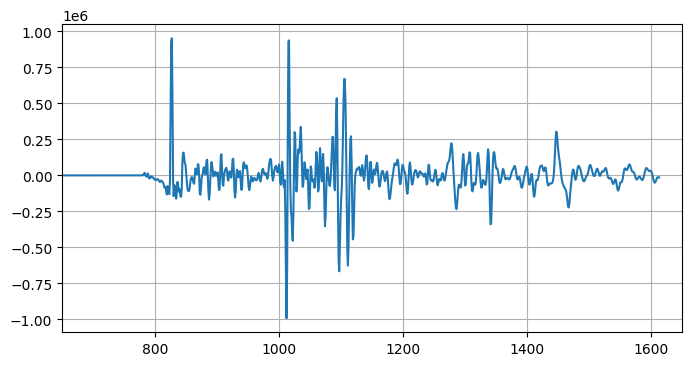

In [37]:
plt.figure(figsize=(8,4))
plt.plot(d[500, 1000, :])
plt.grid()
plt.xlim(650, 1650)

In [38]:
def estimate_wavelet_deterministic(seismic_data, sampling_rate):
    """
    Estimate the deterministic wavelet from seismic data.

    Parameters:
    seismic_data (np.ndarray): The seismic data array.
    tmin (float): The minimum time for the wavelet estimation.
    tmax (float): The maximum time for the wavelet estimation.
    trace_min (int, optional): The minimum trace index for slicing. Defaults to None.
    trace_max (int, optional): The maximum trace index for slicing. Defaults to None.

    Returns:
    pd.DataFrame: A DataFrame containing the time and amplitude of the estimated wavelet.
    np.ndarray: The estimated wavelet.
    np.ndarray: The frequency values.
    np.ndarray: The FFT of the estimated wavelet.
    """
    nt_wav = 16
    nfft = 2**8

    fft_result = np.fft.fft(seismic_data, nfft, axis=-1)

    wav_est_fft = np.mean(np.abs(fft_result), axis=0)

    fwest = np.fft.fftfreq(nfft, d=4 / 1000)
    wav_est = np.real(np.fft.ifft(wav_est_fft)[:nt_wav])
    wav_est = np.concatenate((np.flipud(wav_est[1:]), wav_est), axis=0)
    wav_est = wav_est / wav_est.max()
    fwest = fwest[: nfft // 2]
    wav_est_fft = wav_est_fft[: nfft // 2]

    dt = sampling_rate / 1000  # Assuming the sampling interval is 4 ms
    time_values = np.arange(-nt_wav + 1, nt_wav) * dt
    
    return time_values, wav_est, fwest, wav_est_fft

twav_est, wav_est, fwest, wav_est_fft = estimate_wavelet_deterministic(d[::24, ::4, int(2500//dt) : int(3000//dt)], 4)

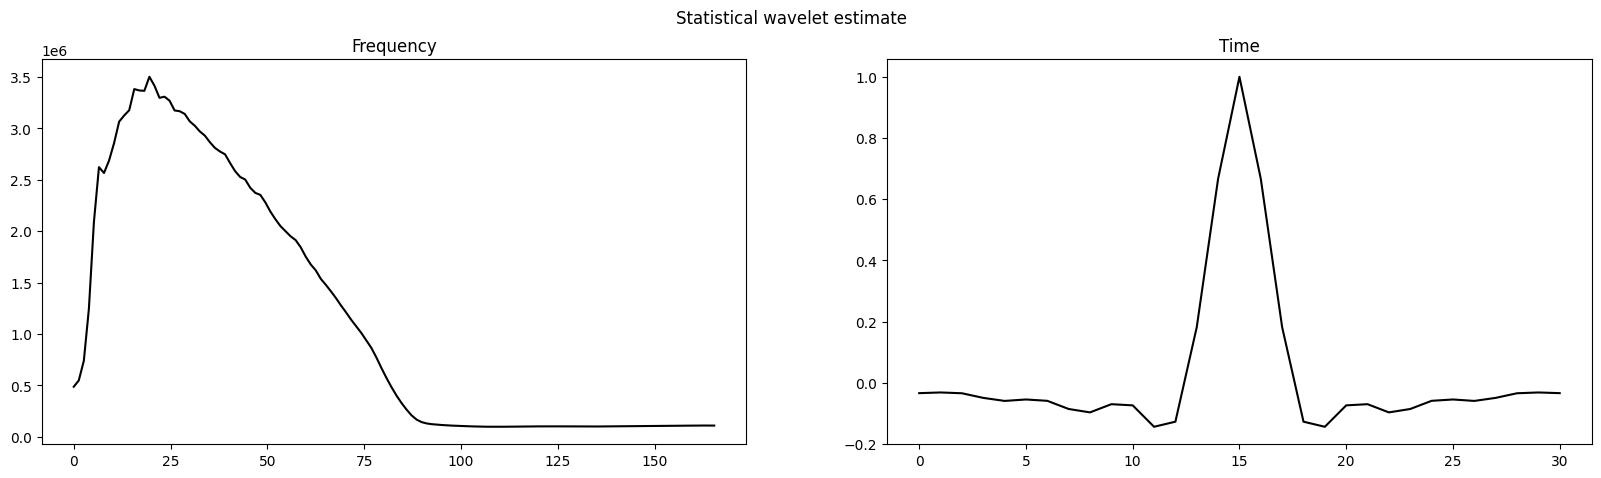

In [41]:
#Another wavelet estimation method

nt_wav = 16 # lenght of wavelet in samples
nfft = 2**8 # lenght of fft

# time axis for wavelet
t_wav = np.arange(nt_wav) * (dt/1000) 
t_wav = np.concatenate((np.flipud(-t_wav[1:]), t_wav), axis=0)

# estimate wavelet spectrum
wav_est_fft = np.mean(np.abs(np.fft.fft(d[..., int(2500/dt):int(3500/dt)], nfft, axis=-1)), axis=(0, 1))#<-----------------Janela da FFT em indice
fwest = np.fft.fftfreq(nfft, d=dt/1000)

# create wavelet in time
wav_est = np.real(np.fft.ifft(wav_est_fft)[:nt_wav])
wav_est = np.concatenate((np.flipud(wav_est[1:]), wav_est), axis=0)
wav_est = wav_est / wav_est.max()
wcenter = np.argmax(np.abs(wav_est))

# display wavelet
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Statistical wavelet estimate')
axs[0].plot(fwest[:nfft//2], wav_est_fft[:nfft//2], 'k')
axs[0].set_title('Frequency')
axs[1].plot(wav_est, 'k')
axs[1].set_title('Time');

In [42]:
nx, ny, nz = d.shape
print(nx, ny, nz)

1720 1300 1614


In [43]:
d_inv2_ppop = pylops.avo.poststack.PoststackLinearModelling(
    wav_est / 2, nt0=nz, spatdims=1, explicit=False
)

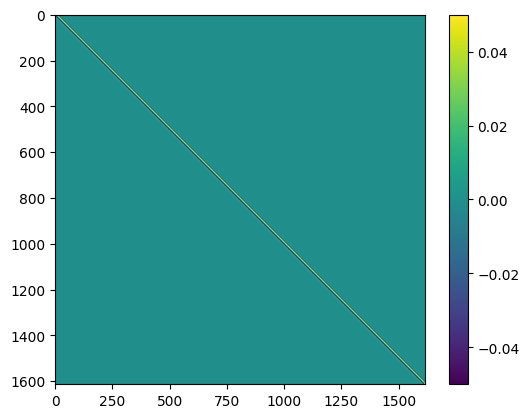

In [47]:
plt.imshow(d_inv2_ppop.todense("numpy"), vmin= -0.05, vmax= 0.05)
plt.colorbar()

In [61]:
d_inv2_tikho = (
    pylops.regularized_inversion(
        Op=d_inv2_ppop,
        y=d[500, 1000, :],
        Regs=[pylops.Identity(nz)],
        epsRs=[0.1],
        x0=np.zeros(d[500, 1000, :].shape),
        engine="scipy",
        **dict(iter_lim=1000)
    )[0]
)

d2op = pylops.SecondDerivative(nz)

d_inv2_smooth = (
    pylops.regularized_inversion(
        Op=d_inv2_ppop,
        y=d[500, 1000, :],
        Regs=[d2op],
        epsRs=[0.1],
        x0=np.zeros(d[500, 1000, :].shape),
        engine="scipy",
        **dict(iter_lim=1000)
    )[0]
)

d2op = pylops.FirstDerivative(nz)

d_inv2_blocky = (
    pylops.regularized_inversion(
        Op=d_inv2_ppop,
        y=d[500, 1000, :],
        Regs=[d2op],
        epsRs=[0.1],
        x0=np.zeros(d[500, 1000, :].shape),
        engine="scipy",
        **dict(iter_lim=1000)
    )[0]
)

(1020.0, 1150.0)

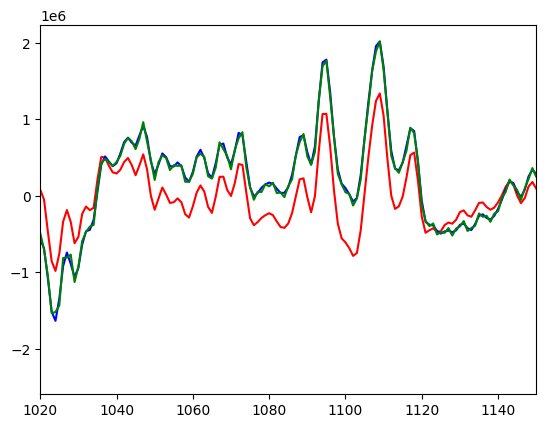

In [66]:
plt.plot(d_inv2_tikho, color = 'red')

plt.plot(d_inv2_smooth, color = 'blue')

plt.plot(d_inv2_blocky, color = 'green')

plt.xlim(1020, 1150)